THIS NOTEBOOK IS A WORK IN PROGRESS
=====================================

I wouldn't even call it a draft yet.

High dimensional data, such as images and sounds often resides in a relatively small subspace of the possible space  of values. It is often of interests to find a representation of the space that permits Latent spaces
unfold MNist, fashion mnist,
use PCA, K-PCA.

If there are subcategories, try discriminators, like LDA (is there an autoencoder equivalent?)

faces
autoencoders
T-SNE

Consider the case where a "direction" is illegal, like deformations of an object on a flat surface.  Can this constraint be learned.

Create a space where the dimensionality is inherently x, and create intra and inter deformations.
- parameterized shapes, like the supershape, or 3D equivalent
- images of these - should they be greyscaled or level setted.

Atlases
 - hypothesize smooth deformations between all of them, but with branches, try to resolve this directionality



In [35]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn.decomposition as decomp
import PIL
from IPython.display import display


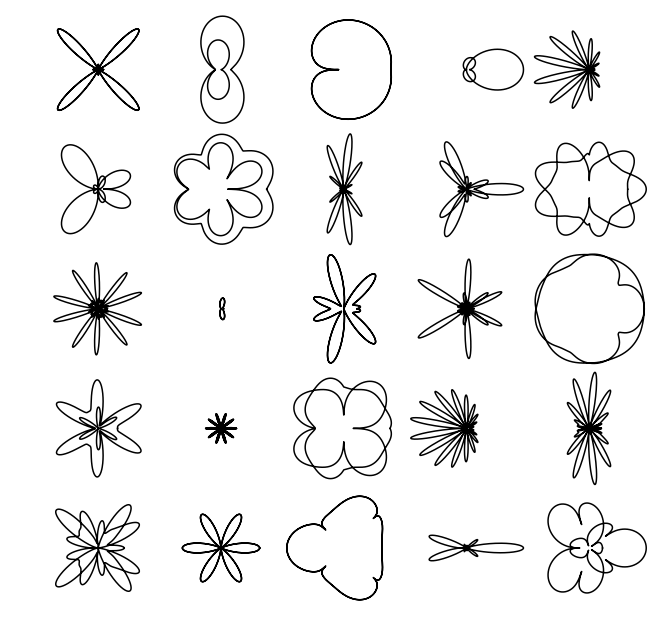

In [3]:
# Superformula
# https://en.wikipedia.org/wiki/Superformula
def superformula(params,theta):
    a,b,m1,m2,n1,n2,n3=params
    r=(0.5*abs(np.cos(m1*theta/4.0))**n2+0.5*abs(np.sin(m2*theta/4.0))**n3)**n1
    return r
    
def supershape(params):
    # return theta and radii
    # here params are a/b ratio, ms and ns scaled to be reasonable between 0 and 1
    #
    thetas=np.linspace(0,4.0*np.pi,2000)
    abratio,m1in,m2in,n1in,n2in,n3in=params
    newa=max(abratio,1.0)
    newb=max(1.0,1.0/abratio)
    m1=np.round(m1in*20.)
    m2=np.round(m2in*20.)
    n1=n1in*5.+1.e-6
    n2=n2in*5.+1.e-6
    n3=n3in*5.+1.e-6
    radii=superformula((newa,newb,m1,m2,n1,n2,n3),thetas)
    return thetas,radii



fig = plt.figure(figsize=(11,11))
for i in range(25):
    thetas,radii=supershape(np.random.rand(6))
    ax = fig.add_subplot(5,5,i+1,aspect='equal')
    xs=np.multiply(np.cos(thetas),radii)
    ys=np.multiply(np.sin(thetas),radii)
    plt.plot(xs,ys,'k')
    ax.axis([-1.05,1.05,-1.05,1.05])
    plt.axis("off")

fig.subplots_adjust(hspace=0, wspace=0)

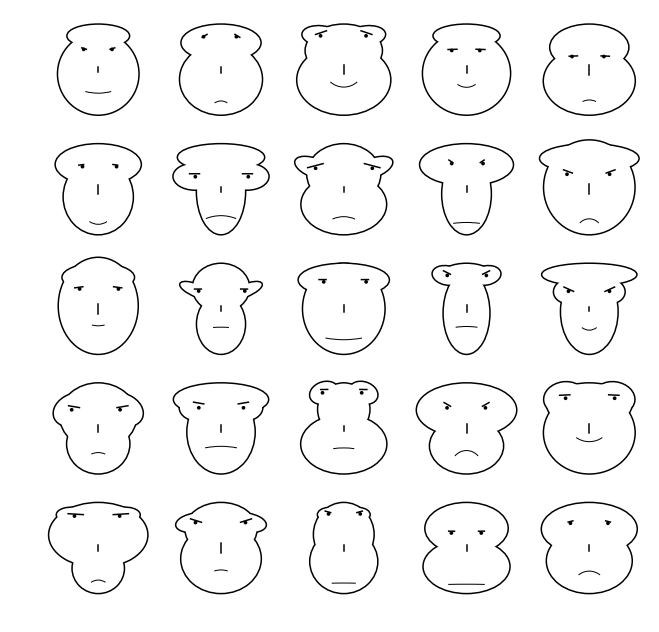

In [20]:
# Chernoff faces
# code based on https://gist.github.com/aflaxman/4043086 with minor modifications

def cface(ax, x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18):
    # x1 = height  of upper face
    # x2 = overlap of lower face
    # x3 = half of vertical size of face
    # x4 = width of upper face
    # x5 = width of lower face
    # x6 = length of nose
    # x7 = vertical position of mouth
    # x8 = curvature of mouth
    # x9 = width of mouth
    # x10 = vertical position of eyes
    # x11 = separation of eyes
    # x12 = slant of eyes
    # x13 = eccentricity of eyes
    # x14 = size of eyes
    # x15 = position of pupils
    # x16 = vertical position of eyebrows
    # x17 = slant of eyebrows
    # x18 = size of eyebrows
    
    # transform some values so that input between 0,1 yields variety of output
    x3 = 1.9*(x3-.5)
    x4 = (x4+.25)
    x5 = (x5+.2)
    x6 = .3*(x6+.01)
    x8 = 5*(2*(x8-0.5))
    if abs(x8)<0.005:  # Allow frowns, they are cute
        x8=0.005
    x11 /= 5
    x12 = 2*(x12-.5)
    x13 += .05
    x14 += .1
    x15 = .5*(x15-.5)
    x16 = .25*x16
    x17 = .5*(x17-.5)
    x18 = .5*(x18+.1)

    lw=3
    pupilsize=0.075
    # top of face, in box with l=-x4, r=x4, t=x1, b=x3
    e = mpl.patches.Ellipse( (0,(x1+x3)/2), 2*x4, (x1-x3), fc='white', linewidth=lw, ec='black')
    ax.add_artist(e)

    # bottom of face, in box with l=-x5, r=x5, b=-x1, t=x2+x3
    e = mpl.patches.Ellipse( (0,(-x1+x2+x3)/2), 2*x5, (x1+x2+x3), fc='white', linewidth=lw, ec='black')
    ax.add_artist(e)
 
    # draw eyes
    p = mpl.patches.Ellipse( (-x11-x14/2,x10), x14, x13*x14, angle=-180/np.pi*x12, facecolor='white', linewidth=lw, ec='black')
    ax.add_artist(p)
    
    p = mpl.patches.Ellipse( (x11+x14/2,x10), x14, x13*x14, angle=180/np.pi*x12, facecolor='white', linewidth=lw, ec='black')
    ax.add_artist(p)

    # cover overlaps
    # top of face
    e = mpl.patches.Ellipse( (0,(x1+x3)/2), 2*x4, (x1-x3), fc='white', ec='none')
    ax.add_artist(e)
    # bottom of face
    e = mpl.patches.Ellipse( (0,(-x1+x2+x3)/2), 2*x5, (x1+x2+x3), fc='white', ec='none')
    ax.add_artist(e)
    # eyes
    p = mpl.patches.Ellipse( (-x11-x14/2,x10), x14, x13*x14, angle=-180/np.pi*x12, facecolor='white', ec='none')
    ax.add_artist(p)
    
    p = mpl.patches.Ellipse( (x11+x14/2,x10), x14, x13*x14, angle=180/np.pi*x12, facecolor='white', ec='none')
    ax.add_artist(p)
    
    # draw nose
    plt.plot([0,0], [-x6/2, x6/2], 'k')
    
    # draw mouth
    p = mpl.patches.Arc( (0,-x7+.5/x8), 1/x8, 1/x8, theta1=270-180/np.pi*np.arctan(abs(x8)*x9), theta2=270+180/np.pi*np.arctan(abs(x8)*x9))
    ax.add_artist(p)
    
    # draw pupils
    p = mpl.patches.Ellipse( (-x11-x14/2-x15*x14/2, x10), pupilsize, pupilsize, facecolor='black')
    ax.add_artist(p)
    p = mpl.patches.Ellipse( (x11+x14/2-x15*x14/2, x10), pupilsize, pupilsize, facecolor='black')
    ax.add_artist(p)
    
    # draw eyebrows
    plt.plot([-x11-x14/2-x14*x18/2,-x11-x14/2+x14*x18/2],[x10+x13*x14*(x16+x17),x10+x13*x14*(x16-x17)],'k')
    plt.plot([x11+x14/2+x14*x18/2,x11+x14/2-x14*x18/2],[x10+x13*x14*(x16+x17),x10+x13*x14*(x16-x17)],'k')

fig = plt.figure(figsize=(11,11))
for i in range(25):
    ax = fig.add_subplot(5,5,i+1,aspect='equal')
    cface(ax, .9, *(np.random.rand(17)*0.5+0.25))
    ax.axis([-1.2,1.2,-1.2,1.2])
    plt.axis("off")

fig.subplots_adjust(hspace=0, wspace=0)

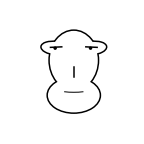

In [81]:
# based on http://www.icare.univ-lille1.fr/tutorials/convert_a_matplotlib_figure
# generate an image from the plot
def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.frombuffer ( fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = ( w, h,4 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll ( buf, 3, axis = 2 )
    return buf

def make_face(params):
    fig=plt.figure(figsize=(2,2))
    ax=plt.gca()
    cface(ax,.9,*(params))
    _=ax.axis([-1.2,1.2,-1.2,1.2])
    _=plt.axis("off")

    Z=fig2data(fig)/255.0
    plt.close(fig)

    Z=1.0-(np.multiply(Z[:,:,0],Z[:,:,3])+(1.0 - Z[:,:,3]))
    return Z.ravel()
def toImage(inImg):
    return np.uint8(np.clip((1.0-inImg.reshape(144,144))*255,0,255))
def toPILImage(inImg):
    return PIL.Image.frombuffer("L",inImg.shape,inImg,"raw","L",0,1)

p=np.random.rand(17)*0.5+0.25
q=make_face(p)
display(toPILImage(toImage(q)))



In [89]:
Params=[np.random.rand(17)*0.5+0.25 for i in range(20)]
Faces=[make_face(p) for p in Params]


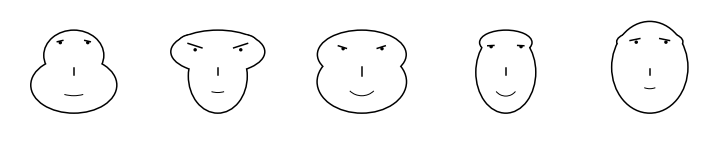

In [90]:
Z=PIL.Image.new("L",(5*144,144))
for i in range(5):
    Z.paste(toPILImage(toImage(Faces[i])),(i*144,0))
display(Z)


17


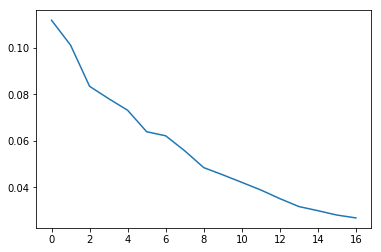

In [92]:
pca=decomp.PCA(svd_solver="full",n_components=0.95)
pca.fit(Faces)
plt.plot(pca.explained_variance_ratio_)
print(pca.n_components_)


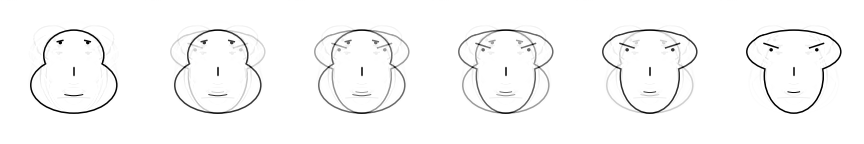

In [93]:
y0=pca.transform([Faces[0]])
y1=pca.transform([Faces[1]])
alphas=np.linspace(0,1,6)
ys=[y0*(1-a)+y1*a for a in alphas]
xs=[pca.inverse_transform([y]) for y in ys]
Z=PIL.Image.new("L",(6*144,144))
for i in range(6):
    Z.paste(toPILImage(toImage(xs[i])),(i*144,0))
display(Z)

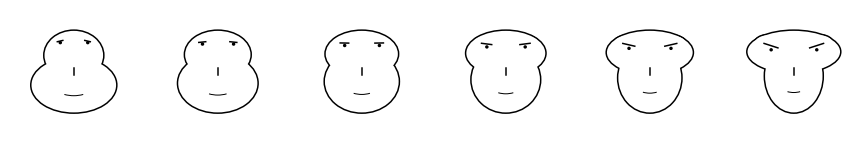

In [91]:
y0=Params[0]
y1=Params[1]
alphas=np.linspace(0,1,6)
ys=[y0*(1-a)+y1*a for a in alphas]
xs=[make_face(y) for y in ys]
Z=PIL.Image.new("L",(6*144,144))
for i in range(6):
    Z.paste(toPILImage(toImage(xs[i])),(i*144,0))
display(Z)

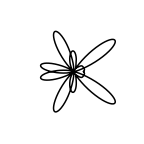

In [107]:
def make_super_image(radii):
    fig=plt.figure(figsize=(2,2))
    ax=plt.gca()
    thetas=np.linspace(0,4.0*np.pi,len(radii))
    xs=np.multiply(np.cos(thetas),radii)
    ys=np.multiply(np.sin(thetas),radii)
    plt.plot(xs,ys,'k')
    _=ax.axis([-1.05,1.05,-1.05,1.05])
    _=plt.axis("off")

    Z=fig2data(fig)/255.0
    plt.close(fig)

    Z=1.0-(np.multiply(Z[:,:,0],Z[:,:,3])+(1.0 - Z[:,:,3]))
    return Z.ravel()
p=np.random.rand(6)
_,r=supershape(p)
q=make_super_image(r)
display(toPILImage(toImage(q)))



In [108]:
Params2=[np.random.rand(6) for i in range(20)]
def get_radius(x):
    _,r=supershape(x)
    return r
Supers=[get_radius(p) for p in Params2]
SuperImages=[make_super_image(s) for s in Supers]


17


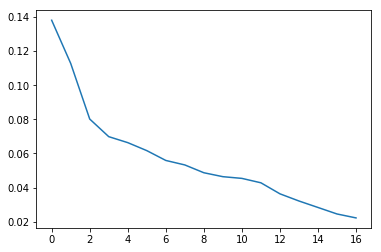

In [109]:
pca_superimages=decomp.PCA(svd_solver="full",n_components=0.95)
pca_superimages.fit(SuperImages)
plt.plot(pca_superimages.explained_variance_ratio_)
print(pca_superimages.n_components_)


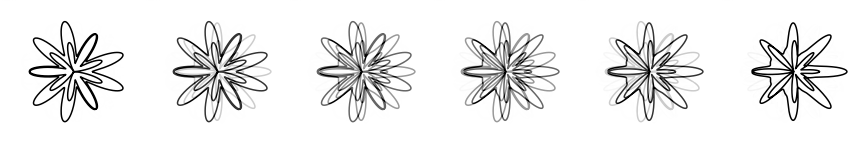

In [111]:
y0=pca_superimages.transform([SuperImages[0]])
y1=pca_superimages.transform([SuperImages[1]])
alphas=np.linspace(0,1,6)
ys=[y0*(1-a)+y1*a for a in alphas]
xs=[pca_superimages.inverse_transform([y]) for y in ys]
Z=PIL.Image.new("L",(6*144,144))
for i in range(6):
    Z.paste(toPILImage(toImage(xs[i])),(i*144,0))
display(Z)

12


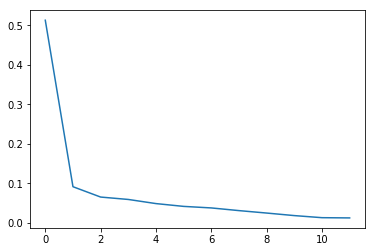

In [112]:
pca_supers=decomp.PCA(svd_solver="full",n_components=0.95)
pca_supers.fit(Supers)
plt.plot(pca_supers.explained_variance_ratio_)
print(pca_supers.n_components_)


[array([[[0.35440486, 0.40082459, 0.41215343, ..., 0.41215343,
         0.40082459, 0.35473409]]]), array([[[0.37559101, 0.40865488, 0.41685837, ..., 0.41685837,
         0.40865488, 0.37581779]]]), array([[[0.39677717, 0.41648517, 0.4215633 , ..., 0.4215633 ,
         0.41648517, 0.39690149]]]), array([[[0.41796332, 0.42431546, 0.42626824, ..., 0.42626824,
         0.42431546, 0.41798518]]]), array([[[0.43914947, 0.43214574, 0.43097317, ..., 0.43097317,
         0.43214574, 0.43906888]]]), array([[[0.46033562, 0.43997603, 0.43567811, ..., 0.43567811,
         0.43997603, 0.46015258]]])]
(1, 1, 2000)
(1, 1, 2000)
(1, 1, 2000)
(1, 1, 2000)
(1, 1, 2000)
(1, 1, 2000)


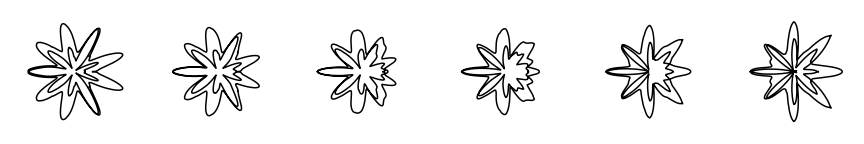

In [117]:
y0=pca_supers.transform([Supers[0]])
y1=pca_supers.transform([Supers[1]])
alphas=np.linspace(0,1,6)
ys=[y0*(1-a)+y1*a for a in alphas]
xs=[pca_supers.inverse_transform([y]) for y in ys]
print(xs)
Z=PIL.Image.new("L",(6*144,144))
for i in range(6):
    print(xs[i].shape)
    Z.paste(toPILImage(toImage(make_super_image(xs[i].flatten()))),(i*144,0))
display(Z)

[array([0.13164223, 0.15877297, 0.89601816, 0.29916857, 0.15121397,
       0.35190177]), array([0.25512136, 0.28886396, 0.78741315, 0.28160608, 0.30800689,
       0.34588721]), array([0.37860049, 0.41895495, 0.67880813, 0.26404358, 0.46479982,
       0.33987266]), array([0.50207962, 0.54904594, 0.57020311, 0.24648109, 0.62159275,
       0.33385811]), array([0.62555875, 0.67913693, 0.46159809, 0.2289186 , 0.77838567,
       0.32784356]), array([0.74903788, 0.80922793, 0.35299307, 0.21135611, 0.9351786 ,
       0.32182901])]


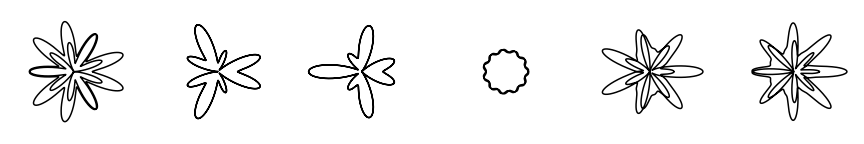

In [121]:
y0=Params2[0]
y1=Params2[1]
alphas=np.linspace(0,1,6)
ys=[y0*(1-a)+y1*a for a in alphas]
print(ys)
supershape(ys[0])
xs=[make_super_image(get_radius(y)) for y in ys]
Z=PIL.Image.new("L",(6*144,144))
for i in range(6):
    Z.paste(toPILImage(toImage(xs[i])),(i*144,0))
display(Z)

processing dist for a=1.00,b=1.00
Integral: 1.00
processing dist for a=1.00,b=2.00
Integral: 1.00
processing dist for a=3.14,b=1.00
Integral: 1.00
processing dist for a=1.00,b=3.14
Integral: 1.00
processing dist for a=2.00,b=1.00
Integral: 1.00
processing dist for a=2.00,b=2.00
Integral: 1.00
processing dist for a=2.00,b=3.14
Integral: 1.00


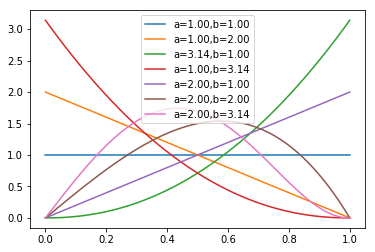

In [172]:
# Kumaraswamy Distribution

def kumaraswamy_pdf(a,b,x):
    tol=0.#1.e-4
    xx=np.clip(x,tol,1.0-tol)
    xa1=np.asarray(xx)**(a-1)
    xa=np.multiply(xa1,xx)
    return a*b*xa1*((1.0-xa)**(b-1))

xs=np.linspace(0,1,1000)
def integrate01(c):
    dx=1.0/(len(c)-1)
    return (np.sum(c)-(c[0]+c[-1])/2.0)*dx

for a,b in [(1.,1.),(1,2),(np.pi,1),(1,np.pi),(2,1),(2,2),(2,np.pi)]:
    print("processing dist for a=%4.2f,b=%4.2f"%(a,b))
    ys=kumaraswamy_pdf(a,b,xs)
    print("Integral: %3.2f"%(integrate01(ys)))
    plt.plot(xs,ys,label="a=%4.2f,b=%4.2f"%(a,b))

plt.legend()

In [173]:
def make_curve(params):
    assert(len(params)%2==0)
    distcount=len(params)/2
    xs=np.linspace(0,1,1000)
    ys=kumaraswamy_pdf(params[0]*9+1,params[1]*9+1,xs)
    for i in range(2,len(params),2):
        ys=ys+kumaraswamy_pdf(params[i]*5+1,params[i+1]*5+1,xs)
    ys=ys/distcount
    return ys



Curve 0: sum: 0.998991 min: 0.000000
Curve 1: sum: 0.998958 min: 0.000000
Curve 2: sum: 0.998932 min: 0.000000
Curve 3: sum: 0.998999 min: 0.000000
Curve 4: sum: 0.998972 min: 0.000000
Curve 5: sum: 0.998863 min: 0.000000
Curve 6: sum: 0.998805 min: 0.000000
Curve 7: sum: 0.998780 min: 0.000000
Curve 8: sum: 0.999000 min: 0.000000
Curve 9: sum: 0.998997 min: 0.000000
Curve 10: sum: 0.998982 min: 0.000000
Curve 11: sum: 0.998794 min: 0.000000
Curve 12: sum: 0.998784 min: 0.000000
Curve 13: sum: 0.998981 min: 0.000000
Curve 14: sum: 0.998995 min: 0.000000
Curve 15: sum: 0.998864 min: 0.000000
Curve 16: sum: 0.998915 min: 0.000000
Curve 17: sum: 0.998991 min: 0.000000
Curve 18: sum: 0.998895 min: 0.000000
Curve 19: sum: 0.998937 min: 0.000000


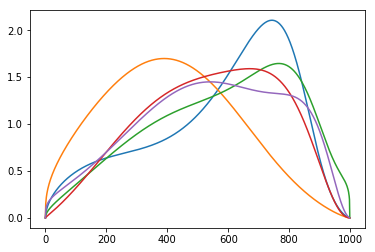

In [174]:
Params3=[np.random.rand(10) for i in range(20)]
Curves=[make_curve(p) for p in Params3]

for i,c in enumerate(Curves):
    print("Curve %d: sum: %f min: %f"%(i,sum(c)/len(c),np.min(c)))

for i in range(5):
    plt.plot(Curves[i])

3


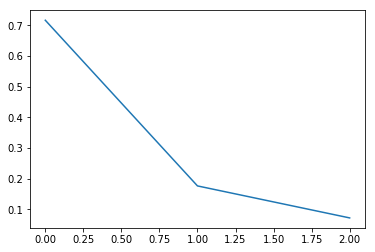

In [175]:
pca_curves=decomp.PCA(svd_solver="full",n_components=0.95)
pca_curves.fit(Curves)
plt.plot(pca_curves.explained_variance_ratio_)
print(pca_curves.n_components_)


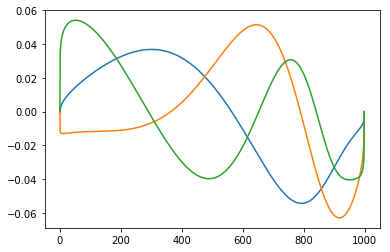

In [176]:
for c in range(pca_curves.n_components_):
    plt.plot(pca_curves.components_[c])

(1000,)
0.9998936455058353
-0.014244140818602424


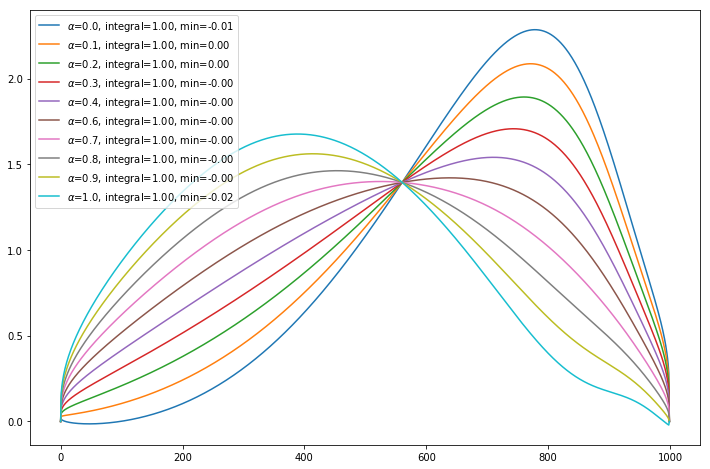

In [184]:
y0=pca_curves.transform([Curves[5]])
y1=pca_curves.transform([Curves[1]])
alphas=np.linspace(0,1,10)
ys=[y0*(1-a)+y1*a for a in alphas]
xs=[pca_curves.inverse_transform([y]).flatten() for y in ys]
print(xs[0].shape)
print(integrate01(xs[0]))
print(np.min(xs[0]))
fig=plt.figure(figsize=(12,8))
for i in range(len(xs)):
    ax=plt.gca()
    ax.plot(xs[i],label=r"$\alpha$=%.1f, integral=%3.2f, min=%3.2f"%(alphas[i],integrate01(xs[i]),np.min(xs[i])))
plt.legend()